In [43]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [63]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
raw = pd.pandas.read_csv('20180608_raw_geo.csv',sep=",",low_memory=False)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import math
from scipy import stats
print("imported " + str(len(raw)) + " rows")

##############################
####    var cleaning     #####
##############################
input = ['living_area','sold_price']
clean = raw
clean = clean[pd.notnull(raw[input]).all(axis=1)] #rowsum booleans for nullvals in col
#clean = raw[pd.notnull(raw['living_area']) & pd.notnull(raw['rooms']) & pd.notnull(raw['floor']) & pd.notnull(raw['sold_price']) & pd.notnull(raw['min_distance_to_metro'])]
print("Removed " +str(len(raw)-len(clean)) + " rows with nulls")


##############################
#### additional features #####
##############################
sqm_price =  pd.DataFrame({'sqm_price':clean.sold_price / clean.living_area}) 
sqm_rent =  pd.DataFrame({'sqm_rent':clean.rent / clean.living_area})
sqm_price_increase =  pd.DataFrame({'sqm_price_increase':(clean.sold_price-clean.list_price) / clean.living_area})
clean = pd.concat([clean , sqm_price, sqm_rent, sqm_price_increase], axis=1)

# time features
#https://pandas.pydata.org/pandas-docs/stable/timeseries.html
sold_datetime =  pd.DataFrame({'sold_datetime': pd.to_datetime(clean['sold_date'])})
published_datetime =  pd.DataFrame({'published_datetime': pd.to_datetime(clean['published'])})
clean = pd.concat([clean , sold_datetime,published_datetime], axis=1)

sold_year = pd.DataFrame({'sold_year': clean['sold_datetime'].dt.year})
sold_month_nbr = pd.DataFrame({'sold_month_nbr': clean['sold_datetime'].dt.month})
sold_year_month = pd.DataFrame({'sold_year_month': clean['sold_datetime'].dt.year*100 + clean['sold_datetime'].dt.month})

#def get_week(row): return row['sold_datetime'].isocalendar()[1]
#sold_week = pd.DataFrame({'sold_week': clean.apply(get_week, axis=1)})

#def get_days_on_market(row): return (row['sold_datetime'] - row['published_datetime']).days
#days_on_market = pd.DataFrame({'days_on_market': clean.apply(get_days_on_market, axis=1)})
#def weekday(row): return (row.dayofweek)
#sold_weekday = pd.DataFrame({'sold_weekday': clean['sold_datetime'].apply(weekday)})
#published_weekday = pd.DataFrame({'published_weekday': clean['published_datetime'].apply(weekday)})

clean = pd.concat([clean 
                   , sold_year
                   ,sold_month_nbr
                   ,sold_year_month
                   #,sold_week
                   #,days_on_market
                   #,sold_weekday
                   #,published_weekday
                  ], axis=1)

areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values
clean = clean[clean['area_from_geo'].isin(areas)]



imported 60503 rows
Removed 145 rows with nulls


## TS plot with seaborn

   area_from_geo  sold_year  sold_month_nbr     sqm_price
0      Södermalm       2015               1  76079.326425
1      Södermalm       2015               2  76430.124965
2      Södermalm       2015               3  81376.978851
3      Södermalm       2015               4  81630.873135
4      Södermalm       2015               5  81052.591870
5      Södermalm       2015               6  80250.864056
6      Södermalm       2015               7  85806.903479
7      Södermalm       2015               8  87427.913421
8      Södermalm       2015               9  88251.411827
9      Södermalm       2015              10  85796.581272
10     Södermalm       2015              11  85565.209749
11     Södermalm       2015              12  87395.020558
12     Södermalm       2016               1  89715.515729
13     Södermalm       2016               2  87250.308612
14     Södermalm       2016               3  87963.627773
15     Södermalm       2016               4  87706.353369
16     Söderma

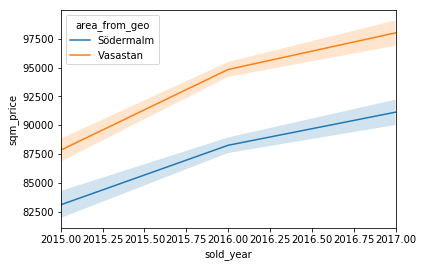

In [8]:
# This timeseries plot is intended to plot deviations in each point. 
# In this example the plot will show the sqm_price per year for two areas. 
# The deviations in each year point comes from the months avg price

# reference: # https://seaborn.pydata.org/generated/seaborn.tsplot.html#seaborn.tsplot

plot_data = clean[ ((clean.area_from_geo == 'Vasastan') | (clean.area_from_geo == 'Södermalm')) & (clean.sold_year < 2018)]
plot_data['time'] = plot_data['sold_year']*100 +plot_data['sold_month_nbr']
# group the data where 
#  - sold_month_nbr will act as the unit (the deviation)
#  - area_from_geo act as the condition (every condition becomes a new line)
#  - sold_year the time (x-axis)
#  - sqm_price the value (y-axis)
grouped_data = (plot_data.groupby(['area_from_geo','sold_year','sold_month_nbr']).mean()['sqm_price']).to_frame()
# reset the index to set the group values in each row 
grouped_data.reset_index(inplace=True)
print(grouped_data.head(24))
ax = sns.tsplot(time="sold_year", value="sqm_price",
                 unit="sold_month_nbr", condition="area_from_geo",
                 data=grouped_data)
plt.show()

## Box Plot with Seaborn

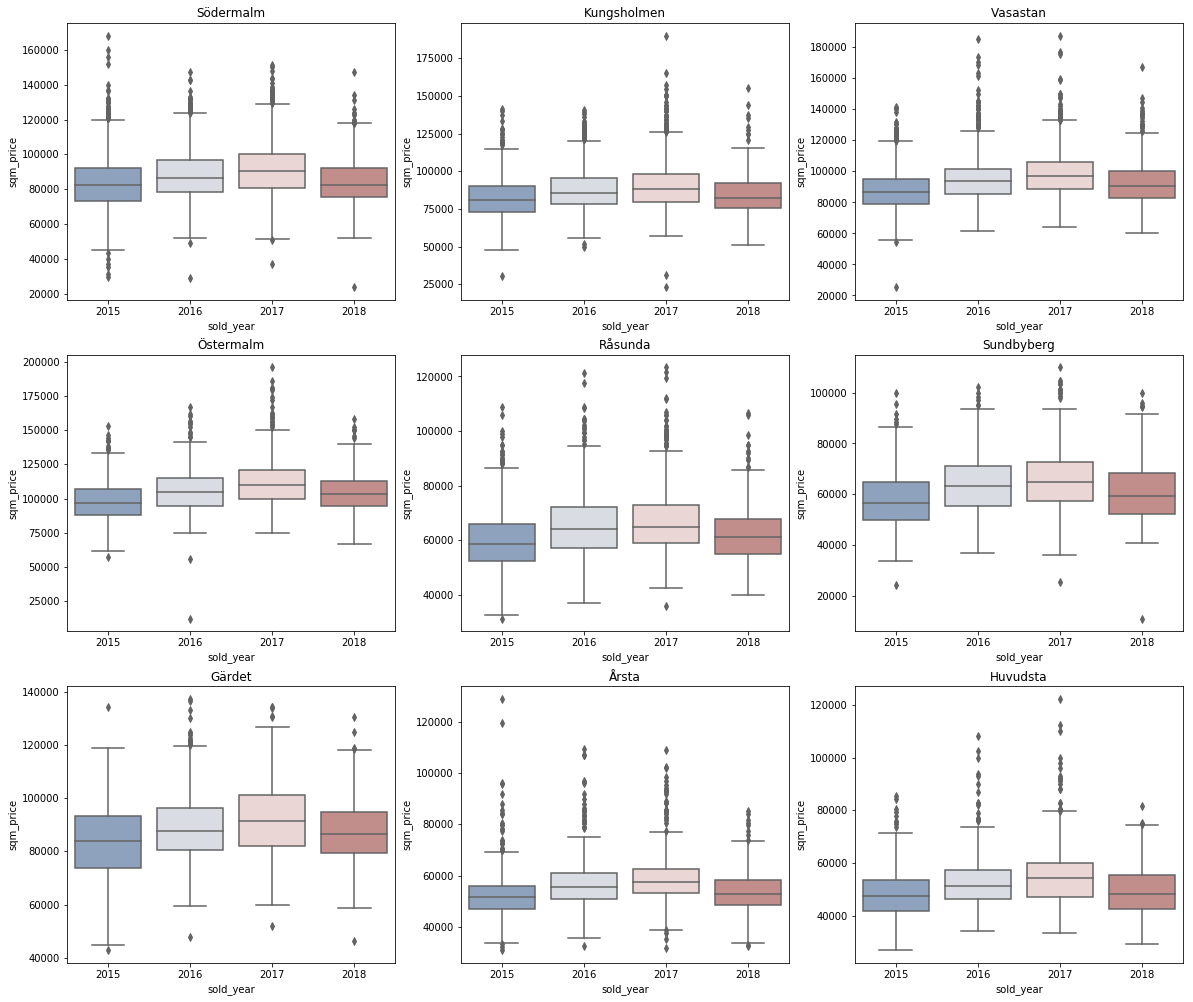

In [6]:
# top 10 areas:
areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values
#print(hej)
plt.subplots(figsize=(20,60))
for i in range(0,len(areas)):
    plt.subplot(10,3,i+1)
    sns.boxplot(x="sold_year", y="sqm_price", data=clean[(clean.area_from_geo == areas[i])] ,palette="vlag").set_title(areas[i])

plt.show()


## Subset data

In [9]:
# https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/
#iloc vs loc

## PairGrid with Seaborn

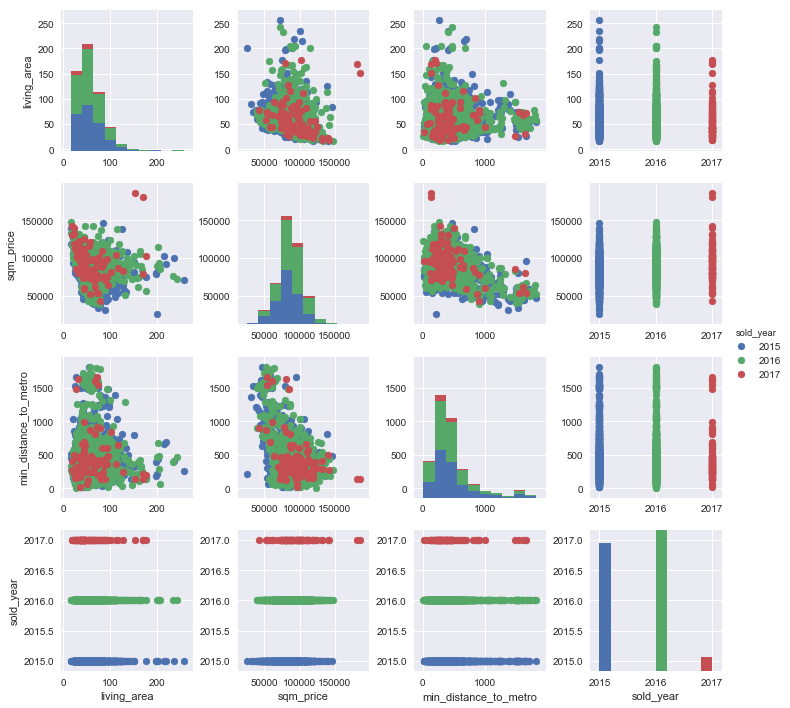

In [77]:
#plot_vars_grid = ['living_area','rooms','floor','sqm_price','sqm_rent','min_distance_to_metro']
plot_vars_grid = ['living_area','sqm_price','min_distance_to_metro', 'sold_year']

data = clean[plot_vars_grid].head(2000)

g = sns.PairGrid(data, hue="sold_year")
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

plt.show()

32348
